In [11]:

import TickLoader

import numpy as np
import pandas as pd
import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import get_ipython
import matplotlib.mlab as mlab
import itertools 


In [12]:
hrs=['03:45:01','10:54:59']
start_datetime = '2018-02-05 '+hrs[0]
end_datetime = '2018-02-20 '+hrs[1]
symbols=['CC  FMK0018!','C   FMK0018!','6BH8']



In [13]:
Raw_data_US=TickLoader.raw_ticks_dataframe(symbols[0], start_datetime, end_datetime,books_type='direct')
Raw_data_UK=TickLoader.raw_ticks_dataframe(symbols[1], start_datetime, end_datetime,books_type='direct')
Raw_data_GBP=TickLoader.raw_ticks_dataframe(symbols[2], start_datetime, end_datetime,books_type='direct')

data_US=Raw_data_US.resample('1S').last()
data_UK=Raw_data_UK.resample('1S').last()
data_GBP=Raw_data_GBP.resample('1S').last()

data_US = data_US.drop(['symbol','instrumentId','trade_price','trade_size','bid_orders','ask_orders'], 1)
data_US = data_US.rename(columns={'bid_price': 'US_bid_price','ask_price': 'US_ask_price','bid_size': 'US_bid_size',
                                 'ask_size': 'US_ask_size', 'mid': 'US_mid', 'wtd_mid': 'US_wtd_mid'})

data_UK = data_UK.drop(['symbol','instrumentId','trade_price','trade_size','bid_orders','ask_orders'], 1)
data_UK = data_UK.rename(columns={'bid_price': 'UK_bid_price','ask_price': 'UK_ask_price','bid_size': 'UK_bid_size',
                                 'ask_size': 'UK_ask_size', 'mid': 'UK_mid', 'wtd_mid': 'UK_wtd_mid'})

data_GBP = data_GBP.drop(['symbol','instrumentId','trade_price','trade_size','bid_orders','ask_orders'], 1)
data_GBP = data_GBP.rename(columns={'bid_price': 'GBP_bid_price','ask_price': 'GBP_ask_price','bid_size': 'GBP_bid_size',
                                 'ask_size': 'GBP_ask_size', 'mid': 'GBP_mid', 'wtd_mid': 'GBP_wtd_mid'})


dataDF=pd.concat([data_US,data_UK,data_GBP],axis=1, join='inner')
dataDF=dataDF.dropna(axis=0,how='any')

Error 1129: 1129: Host '10.9.61.184' is blocked because of many connection errors; unblock with 'mysqladmin flush-hosts'


AttributeError: 'NoneType' object has no attribute 'set_index'

In [5]:
#dataDF=dataDF.assign(arb_mid=US_wtd_mid.values)
#dataDF('arb_mid')=dataDF('US_wtd_mid')

arb_mid=dataDF.US_wtd_mid-dataDF.UK_wtd_mid*dataDF.GBP_wtd_mid/10000
arb_bid=dataDF.US_bid_price-dataDF.UK_ask_price*dataDF.GBP_wtd_mid/10000
arb_ask=dataDF.US_ask_price-dataDF.UK_bid_price*dataDF.GBP_wtd_mid/10000
arb_bid_ask_spread=arb_ask-arb_bid

        
t=range(1,len(arb_mid)+1)


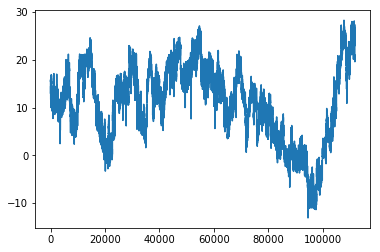

In [6]:

plt.plot(t,arb_mid)
plt.show()

In [20]:
Range=10
MaxPos=200
FairPenalty=float(Range)/float(MaxPos)
taus=[30,60,120,180,240,360,600] #30,120,180,240,360,600
Widths=[0,0.5,0.75,1,1.25,1.5,2,2.5] #0,0.5,1,1.5,2,2.5
pnlDF=pd.DataFrame(index=taus, columns=Widths)
PosDF=pd.DataFrame(index=taus, columns=Widths)
netPnlDF=pd.DataFrame(index=taus, columns=Widths)
volumeDF=pd.DataFrame(index=taus, columns=Widths)
maxminPosDF=pd.DataFrame(index=taus, columns=Widths)

In [21]:
for tau in taus:
    for Width in Widths:

        # Settings
        ema = pd.ewma(arb_mid, span=tau*2) 
        mid_ema=arb_mid-ema

        # Trades
        LTF=ema
        ourPosition=[]
        ourPosition.append(0)
        STF=[]
        ourBid=[]
        ourAsk=[]
        Trades=[]

        for i in range(len(arb_mid)):
            STF.append(LTF[i]-ourPosition[i]*FairPenalty)
            ourBid.append(STF[i]-Width)
            ourAsk.append(STF[i]+Width)
            if  (ourBid[i] > arb_ask[i]).any():
                Trades.append(1)
            elif (ourAsk[i] < arb_bid[i]).any():
                Trades.append(-1)
            else:
                Trades.append(0)
    
            ourPosition.append(np.sum(Trades))

        # PnL
        arbSettle=arb_mid[-1]
        pnl=0
        fees=0
        for r in range(len(Trades)):
            if Trades[r]==1:
                pnl+=(arb_mid[-1]-arb_ask[r])*10
                fees+=-1.35
            if Trades[r]==-1:
                pnl+=(-arb_mid[-1]+arb_bid[r])*10
                fees+=-1.35
        fees+=-ourPosition[-1]*1.35
        netPnl=pnl+fees   

        # Volume
        Volume=0
        for u in range(len(Trades)):
            Volume+=abs(Trades[u])
    
        pnlDF.set_value(tau,Width,pnl)
        netPnlDF.set_value(tau,Width,netPnl)
        PosDF.set_value(tau,Width,ourPosition[-1])
        volumeDF.set_value(tau,Width,Volume)
        maxminPosDF.set_value(tau,Width,max(ourPosition)-min(ourPosition))


/home/local/TMG/samuel.kalt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=60,min_periods=0,adjust=True).mean()
  """
/home/local/TMG/samuel.kalt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:49: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/local/TMG/samuel.kalt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/local/TMG/samuel.kalt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:51: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/local/TMG/samuel.kalt/anaconda2/lib/python2.7/site-packages/ipykernel

In [26]:
netPnlDF


,0.0,0.5,0.75,1.0,1.25,1.5,2.0,2.5
30,4798.52,3472.12,3213.72,2568.85,2233,2308.3,1798.5,1733.39
60,7908.68,5244.42,4926.75,4491.8,4562.21,4120.41,3434.28,2299.22
120,12089.9,9908.37,9889.05,9186.54,8196.94,7611.78,5905.93,3896.3
180,15690.9,13999.9,13952.2,13095.4,11665.4,11164.3,8958.89,5842.06
240,19098.2,17550.3,17038.2,16027.8,14428.8,13347.8,11134.2,7973.36
360,25130.9,22947.3,21838.6,20117.7,18725.1,16976.1,14046.8,10633.3
600,32107.9,28820.2,27215.1,25180.5,23466.1,21424.3,17909,14035.7


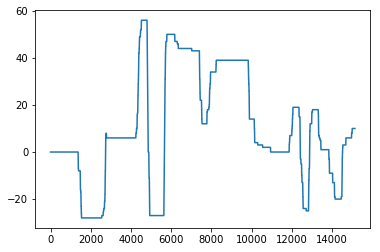

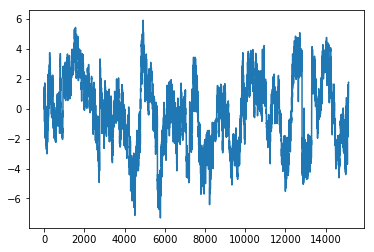

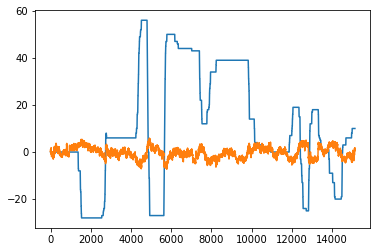

56

In [23]:
plt.plot(t,ourPosition[:-1])
plt.show()
plt.plot(t,mid_ema)
plt.show()
plt.plot(t,ourPosition[:-1],t,mid_ema)
plt.show()

max(ourPosition)

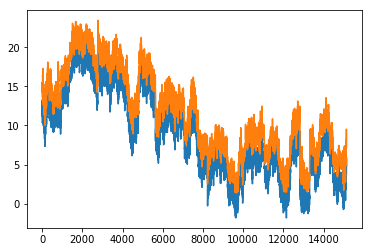

In [24]:
plt.plot(t,arb_bid,t,arb_ask)
plt.show()